In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

In [2]:
# Generate uniform spherical distribution of 100,000 vertices by Gaussian sampling (https://mathworld.wolfram.com/SpherePointPicking.html)
number_of_vertices = 10000

vertex_positions = np.random.randn(number_of_vertices, 3)
vertex_positions /= np.linalg.norm(vertex_positions, axis=1, keepdims=True)

In [3]:
# Load vertices into HooMD snapshot
snapshot = build.get_simulation_box(box_length=3)

build.set_membrane_vertices(snapshot, vertex_positions)

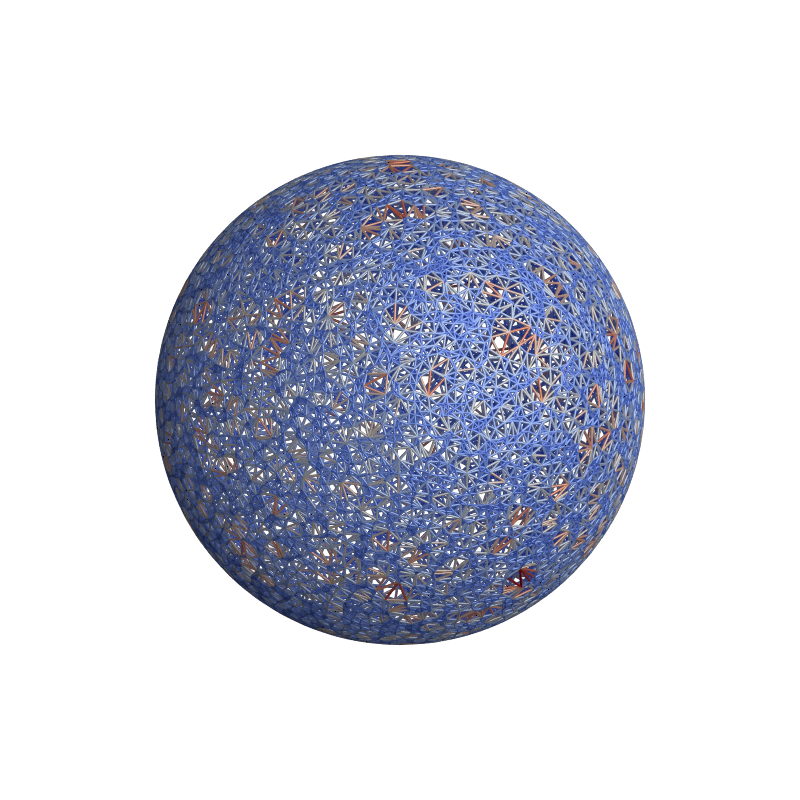

In [4]:
# Visualize the resulting mesh using Fresnel
vertex_rescale_factor = 0.01
snapshot.particles.diameter *= vertex_rescale_factor

render.fresnel(snapshot, outline=0, show='strains', cmap='coolwarm').static(height=800, width=800)

In [5]:
# That does not look very homogeneous! 
# Let's try to achieve a more regular mesh by solving the Thomson problem using HooMD (https://en.wikipedia.org/wiki/Thomson_problem)
vertex_positions_thomson = build.get_thomson_distribution(number_of_vertices)

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM
Simulation.timestep  Simulation.tps     Status.etr    Thermo.potential_energy
       5000            478.38181      0:03:18.586145        4.94487e+07      
       10000           543.29163      0:02:45.656886        4.94480e+07      
       15000           568.26048      0:02:29.579293        4.94479e+07      
       20000           581.22346      0:02:17.640694        4.94477e+07      
       25000           588.84447      0:02:07.368097        4.94476e+07      
       30000           593.55068      0:01:57.934326        4.94476e+07      
       35000           596.73996      0:01:48.925167        4.94475e+07      
       40000           598.94180      0:01:40.176679        4.94475e+07      
       45000           600.77452      0:01:31.548489        4.94475e+07      
       50000           602.17355      0:01:23.032541        4.94475e+07      
       55000           603.26134    

In [6]:
# Load vertices into new HooMD snapshot
snapshot_thomson = build.get_simulation_box(box_length=3)

build.set_membrane_vertices(snapshot_thomson, vertex_positions_thomson)

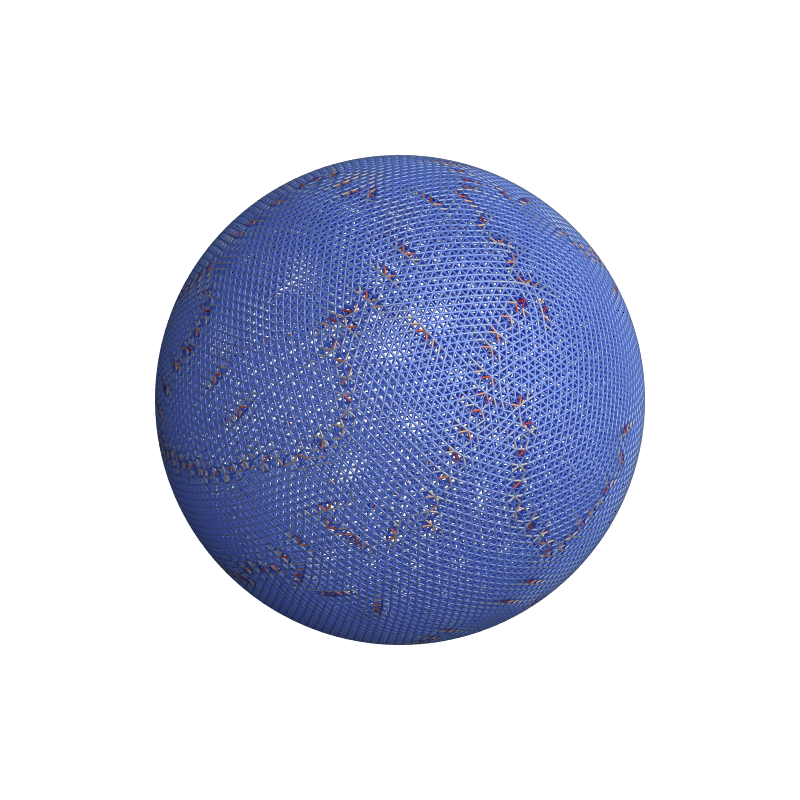

In [7]:
# That new mesh seems much better behaved! 
# Dislocation lines ('scars') still necessarily remain, as imposed by Euler's formula (https://en.wikipedia.org/wiki/Euler_characteristic) 
snapshot_thomson.particles.diameter *= vertex_rescale_factor

render.fresnel(snapshot_thomson, outline=0, show='strains', cmap='coolwarm').static(height=800, width=800)

In [8]:
# Rescale membrane diameter such that the mean mesh edge length equals 1 (i.e., 50 nm in physical units)
# This yields a membrane diameter of ~2.6 um
rescale_factor = np.sqrt(np.sqrt(3)*number_of_vertices/(8*np.pi))

vertex_rescale_factor *= rescale_factor
vertex_positions = vertex_positions_thomson * rescale_factor

In [9]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM


In [10]:
# Generate RNG seed & initialize simulation object
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 26651


In [11]:
# Initialize simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [12]:
# Load vertices into simulation
snapshot = build.get_simulation_box(box_length=3*rescale_factor)

build.set_membrane_vertices(snapshot, vertex_positions)
system.create_state_from_snapshot(snapshot)

In [13]:
# At T=300K, these numbers yield a membrane Young's modulus of 25 mN/m and bending modulus of 1e−19 J (https://arxiv.org/pdf/2107.02598)
with open("force_dict_membrane.json", 'r') as dict_file:
    force_dict = json.load(dict_file)
    
print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Bonded forces": {
        "Membrane": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.028
        }
    },
    "Dihedral forces": {
        "Curvature": {
            "Phi_0": 0,
            "Stiffness": 30.0,
            "Type": "Harmonic"
        }
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "Vertices": {
                    "Vertices": 100.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set neighbor list & excluded volume
nl = hoomd.md.nlist.Cell(buffer=0.4)
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [15]:
# Set bonded/dihedral potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
dihedral_forces = forces.get_dihedral_forces(**force_dict)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/dihedral.py:131: FutureWarning: Harmonic is deprecated and will be removed in hoomd 4.0. Use Periodic instead.
  warnings.warn(


In [16]:
# Define elastic force field
relax_field = bonded_forces + dihedral_forces

In [17]:
# Setup minimisation engine to relax mesh structure
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
fire = hoomd.md.minimize.FIRE(dt=1e-4, methods=[nve], forces=relax_field,
                              force_tol=5e-2, angmom_tol=5e-2, energy_tol=5e-2)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [18]:
# Setup log and integrators
logger_relax = log.get_logger(system, quantities=['potential_energy'])

system.operations.integrator = fire
system.operations.writers.append(log.table_formatter(logger_relax, period=1e4))

In [19]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.potential_energy
       10000           7192.06090     0:00:26.418019        14458.82944      
       20000           8019.73274     0:00:22.444638        12942.55931      
       30000           8343.77499     0:00:20.374471        12793.74118      
       40000           8512.43773     0:00:18.796026        12673.76398      
       50000           8620.04611     0:00:17.401299        12577.08796      
       60000           8694.43619     0:00:16.102252        12547.03317      
       70000           8744.11372     0:00:14.867144        12494.92847      
       80000           8786.49323     0:00:13.657326        12485.94086      
       90000           8819.26643     0:00:12.472693        12463.19223      
      100000           8845.94396     0:00:11.304616        12453.61905      
      110000           9603.55216     0:00:09.371532        12452.24892      
      120000          10464.97766     0:00:07.644546        1245

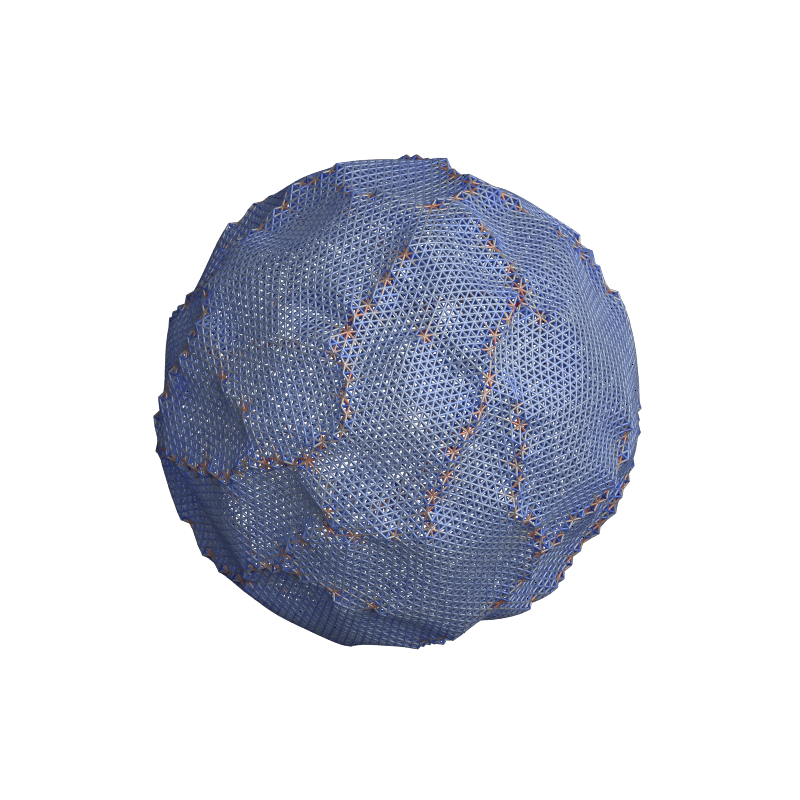

In [20]:
# Visualize relaxed mesh
snapshot_relaxed = system.state.get_snapshot()

render.fresnel(snapshot_relaxed, show='strains', cmap='coolwarm', outline=0, rescale_backbone_bonds=vertex_rescale_factor).static(height=800, width=800)

In [21]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [22]:
# Set full force field
force_field = relax_field + repulsion_forces

In [23]:
# Unset relaxation engine
system.operations.remove(fire)
system.operations.remove(system.operations.writers[0])

In [24]:
# Initialize Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=10*t_conv, methods=[langevin], forces=force_field)

In [25]:
# Update simulation object
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=5e4))

In [26]:
# Run
system.run(1e6)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      250000           9736.63435     0:01:37.569649           0.99435          
      300000           9929.39928     0:01:30.639924           0.99980          
      350000          10023.33381     0:01:24.802124           1.00324          
      400000          10072.48194     0:01:19.424317           1.00013          
      450000          10095.74805     0:01:14.288700           0.99900          
      500000          10115.91017     0:01:09.197926           1.00525          
      550000          10131.83172     0:01:04.154244           0.99246          
      600000          10143.66252     0:00:59.150233           0.99726          
      650000          10153.43201     0:00:54.168876           0.99920          
      700000          10159.44426     0:00:49.215290           0.99420          
      750000          10162.76830     0:00:44.279274           1.00145          
      800000          10167.

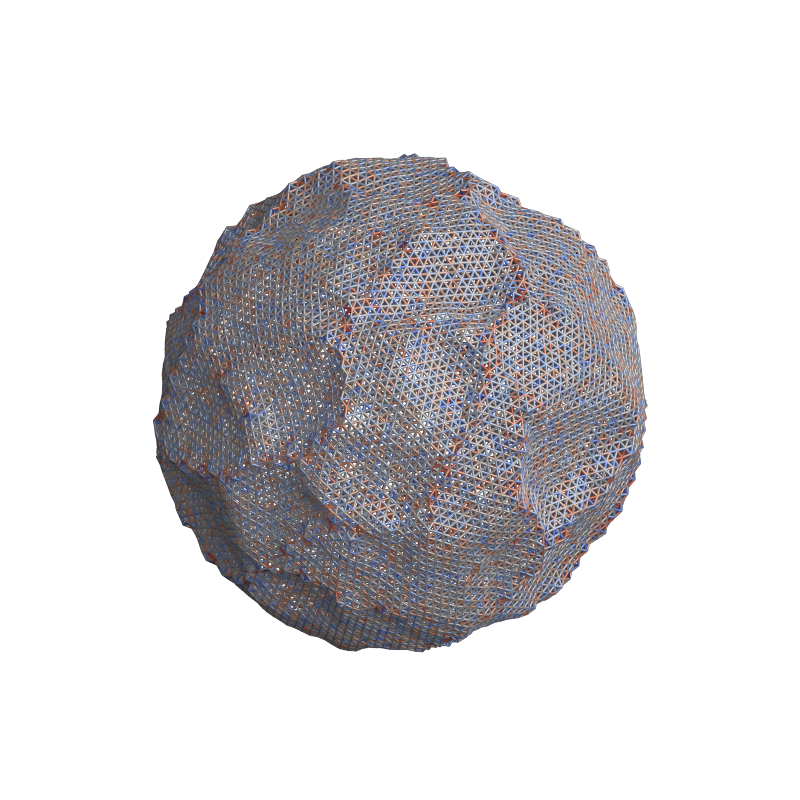

In [27]:
# Visualize thermalized membrane
snapshot_therm = system.state.get_snapshot()

render.fresnel(snapshot_therm, show='strains', cmap='coolwarm', outline=0, rescale_backbone_bonds=vertex_rescale_factor).static(height=800, width=800)